In [1]:
from pathlib import Path
import numpy as np
import supervision as sv
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

In [2]:
PATH_MAT = Path("./material")
PATH_IMGS = PATH_MAT / "images"
PATH_TEMPLATE = PATH_MAT / "template" / "pattern.png"

In [4]:
# util para generar color
def str_to_opencv(color: str) -> tuple[int,int,int]:
    rgb = to_rgb(color)
    return tuple(int(255*x) for x in rgb[::-1])

# mostramos para rojo y negro
str_to_opencv('red'), str_to_opencv('black')

((0, 0, 255), (0, 0, 0))

In [7]:
# utils
def plot_boxes(
        boxes: list[tuple[int,int,int,int]] | np.ndarray,
        scores: list[float] | np.ndarray | None,
        base_img: np.ndarray,
        color: tuple[int,int,int] | str = (0,0,255),
        width: int = 2,
        fontScale: float = 0.35,
        fontWidth: int = 1
):
    img_copy = base_img.copy()

    if isinstance(boxes, np.ndarray):
        boxes = boxes.tolist()

    if scores is not None and isinstance(scores,np.ndarray):
        scores = scores.tolist()
    elif scores is None:
        scores = [None] * len(boxes)

    if isinstance(color, str):
        color = str_to_opencv(color)

    for (x1,y1,x2,y2),score in zip(boxes, scores):
        cv.rectangle(img_copy, (x1,y1), (x2,y2), color, width)
        if score is not None:
            label = str(round(score, 3))
            (label_width, label_height), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, fontScale, fontWidth)

            text_end = (x1 + label_width, y1 - label_height)
            cv.rectangle(img_copy, (x1,y1), text_end, (0,0,0),-1)
            cv.putText(img_copy, label, (x1,y1), cv.FONT_HERSHEY_SIMPLEX, fontScale, (255,255,255), fontWidth)
        
    sv.plot_image(img_copy)

In [5]:
IMGS = {p.name[:-4]:p for p in PATH_IMGS.iterdir()}
IMGS

{'COCA-COLA-LOGO': PosixPath('material/images/COCA-COLA-LOGO.jpg'),
 'coca_logo_2': PosixPath('material/images/coca_logo_2.png'),
 'coca_multi': PosixPath('material/images/coca_multi.png'),
 'logo_1': PosixPath('material/images/logo_1.png'),
 'coca_logo_1': PosixPath('material/images/coca_logo_1.png'),
 'coca_retro_2': PosixPath('material/images/coca_retro_2.png'),
 'coca_retro_1': PosixPath('material/images/coca_retro_1.png')}

In [9]:
MIN_BEST_METHODS = {cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED}

In [10]:
DEFAULT_PLOT_PARAMS = dict(
    fontWidth=1, 
    fontScale=0.35, 
    color='blue'
)

Probamos nuevo pipeline:

1. Pasaje a grayscale
2. Resizing del template
3. Gaussian Blur sobre imagen base (opc.)
4. Gaussian Blur sobre template (opc.)
5. Canny (post-resize)
6. Template Matching sobre Canny
7. NMS

In [55]:
def multi_detection(
    img: np.ndarray,
    template: np.ndarray,
    method: int = cv.TM_CCOEFF_NORMED,
    threshold: float = 0.8,
    nms_max_overlap: float = 0.4,
    scale_range: tuple[float, float] = (0.2, 2),
    scale_step: float = 0.1,
    canny_thresholds: tuple[int,int] = (100, 200),
    blur_template_sigma: float | None = 0.5,
    blur_template_k: int = 3,
    blur_img_sigma: float | None = 0.5,
    blur_img_k: int = 3,
    debug: bool = False,
    plot: bool = False,
    plot_params: dict = DEFAULT_PLOT_PARAMS
) -> tuple[list[tuple[int, int, int, int]], list[float]]:
    
    # grayscale both
    img_gs = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

    # blur img if specified
    if blur_img_sigma is not None:
        img_gs = cv.GaussianBlur(img_gs, 
                                 (blur_img_k, blur_img_k), 
                                 sigmaX=blur_img_sigma, sigmaY=blur_img_sigma)
    

    # canny on img
    img_edges = cv.Canny(img_gs, *canny_thresholds)

    # build iterator
    def scale_iter():
        min_scale, max_scale = scale_range
        h_img, w_img = img_gs.shape
        h_temp, w_temp = template.shape

        # ratio at which template is as big as image
        h_ratio = h_img / h_temp
        w_ratio = w_img / w_temp    
        if debug:
            print(f"H-W ratios: ({h_ratio:.3f},{w_ratio:.3f})")
        # double for with optimized bounds
        for scale_x in np.arange(min_scale,
                                 min(max_scale, w_ratio)+scale_step,
                                 scale_step):
            for scale_y in np.arange(min_scale,
                                     min(max_scale, h_ratio)+scale_step,
                                     scale_step):
                yield scale_x.item(), scale_y.item()
    
    # init results
    boxes = []
    scores = []
    running_best = -999
    if method in MIN_BEST_METHODS:
        running_best *= -1

    # for each scale on X and Y...
    for scale_x, scale_y in scale_iter():
        # resize template
        scaled_template = cv.resize(
            template, None, 
            fx=scale_x, fy=scale_y, 
            interpolation=cv.INTER_LINEAR
        ) # type: ignore

        # double check
        h, w = scaled_template.shape
        if img_edges.shape[0] < h or img_edges.shape[1] < w:
            if debug:
                print(f"Scale {scale_x}, {scale_y} out of base image bounds")
            continue
        
        # blur template if specified
        if blur_template_sigma is not None:
            scaled_template = cv.GaussianBlur(scaled_template,
                                              (blur_template_k, blur_template_k),
                                              sigmaX=blur_template_sigma, 
                                              sigmaY=blur_template_sigma)
        
        # canny on resized template
        template_edges = cv.Canny(scaled_template, *canny_thresholds)

        # template matching
        result = cv.matchTemplate(img_edges, template_edges, method)

        # get indices + confidence scores
        if method in MIN_BEST_METHODS:
            match_indices = np.where(result <= threshold)
            confidences = 1.0 - result[match_indices]
            running_best = min(running_best, result.min())
        else:
            match_indices = np.where(result >= threshold)
            confidences = result[match_indices]
            running_best = max(running_best, result.max())

        # debugging
        if debug:
            print("".join([
                f"Scale {scale_x:>.3f}, {scale_y:>.3f}:",
                f"[{result.min().round(3).item():<.4f}, {result.max().round(3).item():>.4f}]",
                f" pre-NMS={len(confidences)}"]))
    
        # append results
        #for (y, x), conf in zip(zip(*match_indices), confidences):
        #    boxes.append([x, y, x+w, y+h])
        #    scores.append(conf.item())
        boxes.extend([(x, y, x+w, y+h) for y,x in zip(*match_indices)])
        scores.extend(confidences.tolist())
            
    # build Detections
    if not boxes:
        if debug:
            print("No detections found, best was",running_best)
        return [], []

    detections = sv.Detections( 
        xyxy=np.array(boxes),
        confidence=np.array(scores)
    )
    detections = detections.with_nms(threshold=nms_max_overlap, class_agnostic=True)
    xyxy = detections.xyxy.tolist()
    confidences = detections.confidence.tolist()

    if plot:
        plot_boxes(xyxy, confidences, img, **plot_params)
    
    return xyxy, confidences

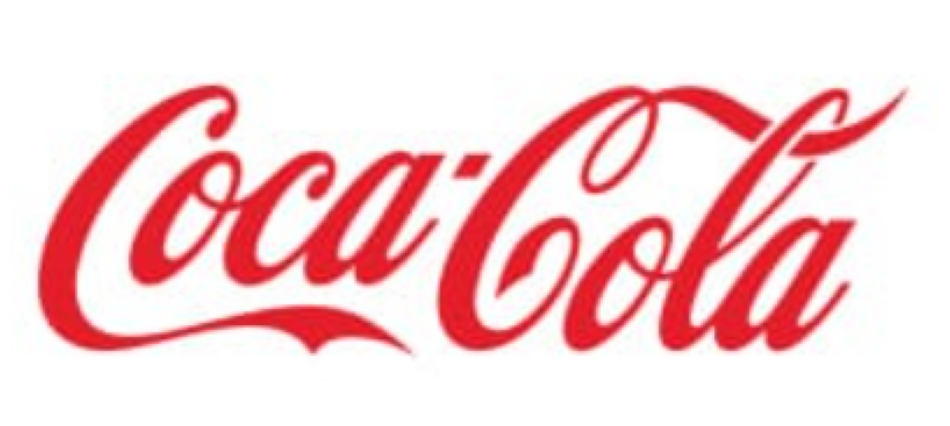

In [27]:
# levantamos el template
template = cv.imread(PATH_TEMPLATE)

sv.plot_image(template)

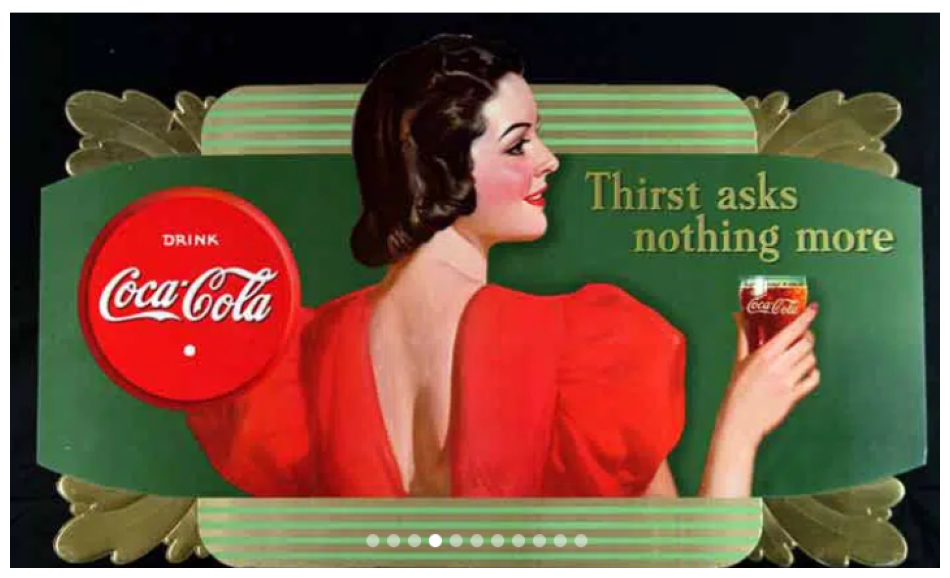

In [28]:
# levantamos la de siempre
img_rgb = cv.imread(IMGS['coca_retro_2'])

sv.plot_image(img_rgb)

H-W ratios: (2.451,1.788)
Scale 0.200, 0.200:[-0.1500, 0.2140] pre-NMS=0
Scale 0.200, 0.300:[-0.1280, 0.1630] pre-NMS=0
Scale 0.200, 0.400:[-0.1170, 0.1810] pre-NMS=0
Scale 0.200, 0.500:[-0.1170, 0.1320] pre-NMS=0
Scale 0.200, 0.600:[-0.1120, 0.1350] pre-NMS=0
Scale 0.200, 0.700:[-0.1050, 0.1340] pre-NMS=0
Scale 0.200, 0.800:[-0.1010, 0.1210] pre-NMS=0
Scale 0.200, 0.900:[-0.1030, 0.1180] pre-NMS=0
Scale 0.200, 1.000:[-0.1060, 0.1160] pre-NMS=0
Scale 0.200, 1.100:[-0.1060, 0.1110] pre-NMS=0
Scale 0.200, 1.200:[-0.1040, 0.1100] pre-NMS=0
Scale 0.200, 1.300:[-0.1000, 0.1050] pre-NMS=0
Scale 0.200, 1.400:[-0.0850, 0.0960] pre-NMS=0
Scale 0.200, 1.500:[-0.0770, 0.1000] pre-NMS=0
Scale 0.200, 1.600:[-0.0700, 0.1010] pre-NMS=0
Scale 0.200, 1.700:[-0.0690, 0.0950] pre-NMS=0
Scale 0.200, 1.800:[-0.0730, 0.0960] pre-NMS=0
Scale 0.200, 1.900:[-0.0740, 0.0980] pre-NMS=0
Scale 0.200, 2.000:[-0.0800, 0.0980] pre-NMS=0
Scale 0.300, 0.200:[-0.1360, 0.1760] pre-NMS=0
Scale 0.300, 0.300:[-0.1110, 0.166

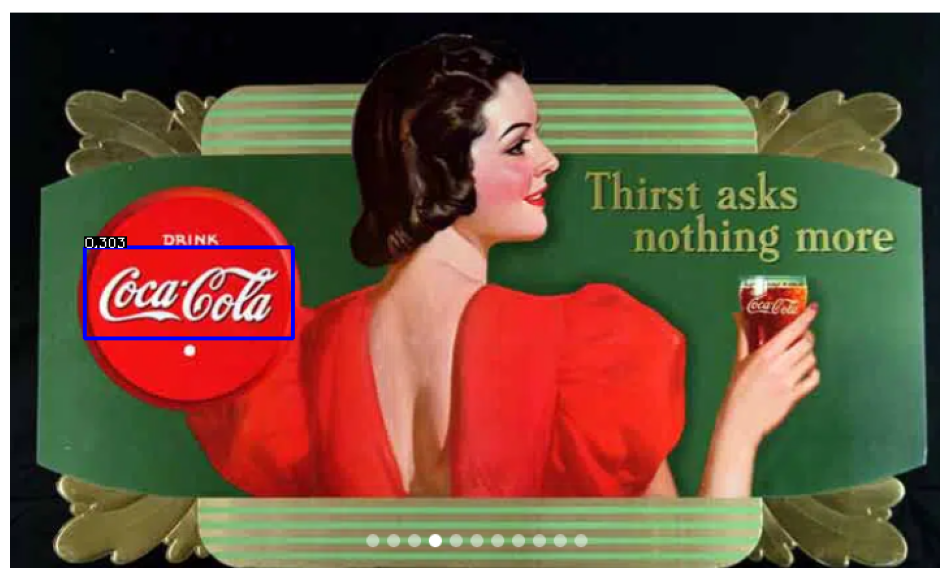

In [29]:
dets, scores = multi_detection(
    img_rgb,
    template,
    #method=cv.TM_CCORR_NORMED,
    #threshold=0.3,
    threshold=0.25,
    debug=True,
    plot=True
)

H-W ratios: (2.817,1.788)
Scale 0.200, 0.200:[-0.0000, 0.3410] pre-NMS=393
Scale 0.200, 0.300:[-0.0000, 0.3150] pre-NMS=5
Scale 0.200, 0.400:[-0.0000, 0.2930] pre-NMS=0
Scale 0.200, 0.500:[-0.0000, 0.2980] pre-NMS=0
Scale 0.200, 0.600:[-0.0000, 0.2800] pre-NMS=0
Scale 0.200, 0.700:[-0.0000, 0.2750] pre-NMS=0
Scale 0.200, 0.800:[-0.0000, 0.2700] pre-NMS=0
Scale 0.200, 0.900:[-0.0000, 0.2500] pre-NMS=0
Scale 0.200, 1.000:[-0.0000, 0.2460] pre-NMS=0
Scale 0.200, 1.100:[-0.0000, 0.2370] pre-NMS=0
Scale 0.200, 1.200:[-0.0000, 0.2350] pre-NMS=0
Scale 0.200, 1.300:[-0.0000, 0.2290] pre-NMS=0
Scale 0.200, 1.400:[-0.0000, 0.2230] pre-NMS=0
Scale 0.200, 1.500:[-0.0000, 0.2230] pre-NMS=0
Scale 0.200, 1.600:[-0.0000, 0.2190] pre-NMS=0
Scale 0.200, 1.700:[-0.0000, 0.2070] pre-NMS=0
Scale 0.200, 1.800:[-0.0000, 0.2040] pre-NMS=0
Scale 0.200, 1.900:[-0.0000, 0.2030] pre-NMS=0
Scale 0.200, 2.000:[-0.0000, 0.2020] pre-NMS=0
Scale 0.300, 0.200:[-0.0000, 0.3240] pre-NMS=47
Scale 0.300, 0.300:[-0.0000, 0.

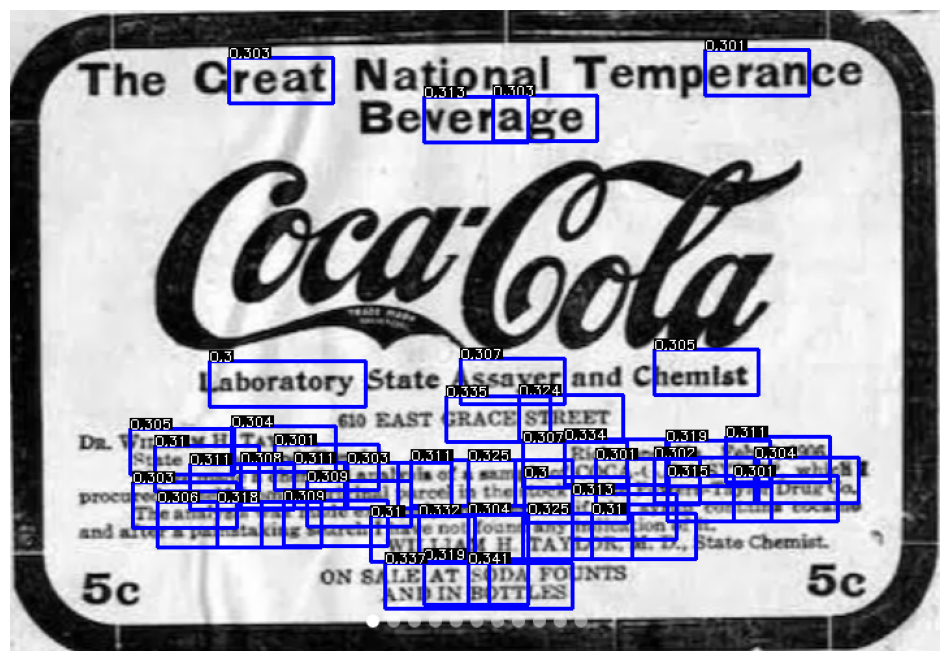

In [35]:
# otra
dets, scores = multi_detection(
    cv.imread(IMGS['coca_retro_1']),
    template,
    method=cv.TM_CCORR_NORMED,
    threshold=0.3,
    #threshold=0.2,
    debug=True,
    plot=True
)

**ANDA MAL!**

In [40]:
# otra
dets, scores = multi_detection(
    cv.imread(IMGS['COCA-COLA-LOGO']),
    template,
    #method=cv.TM_CCORR_NORMED,
    scale_range=(2,5),
    threshold=0.05,
    #threshold=0.3,
    #threshold=0.2,
    debug=True,
    plot=True
)

H-W ratios: (7.937,3.473)
Scale 2.000, 2.000:[-0.0230, 0.0330] pre-NMS=0
Scale 2.000, 2.100:[-0.0240, 0.0320] pre-NMS=0
Scale 2.000, 2.200:[-0.0240, 0.0290] pre-NMS=0
Scale 2.000, 2.300:[-0.0240, 0.0310] pre-NMS=0
Scale 2.000, 2.400:[-0.0230, 0.0290] pre-NMS=0
Scale 2.000, 2.500:[-0.0220, 0.0270] pre-NMS=0
Scale 2.000, 2.600:[-0.0220, 0.0260] pre-NMS=0
Scale 2.000, 2.700:[-0.0210, 0.0270] pre-NMS=0
Scale 2.000, 2.800:[-0.0220, 0.0270] pre-NMS=0
Scale 2.000, 2.900:[-0.0210, 0.0250] pre-NMS=0
Scale 2.000, 3.000:[-0.0200, 0.0250] pre-NMS=0
Scale 2.000, 3.100:[-0.0200, 0.0230] pre-NMS=0
Scale 2.000, 3.200:[-0.0190, 0.0220] pre-NMS=0
Scale 2.000, 3.300:[-0.0190, 0.0240] pre-NMS=0
Scale 2.000, 3.400:[-0.0190, 0.0210] pre-NMS=0
Scale 2.000, 3.500:[-0.0180, 0.0200] pre-NMS=0
Scale 2.000, 3.600:[-0.0180, 0.0200] pre-NMS=0
Scale 2.000, 3.700:[-0.0180, 0.0230] pre-NMS=0
Scale 2.000, 3.800:[-0.0170, 0.0200] pre-NMS=0
Scale 2.000, 3.900:[-0.0170, 0.0200] pre-NMS=0
Scale 2.000, 4.000:[-0.0170, 0.024

Este no anda sin escalar la imagen como _draft2_ con el scaling de Gustavo.

H-W ratios: (2.857,0.517)
Scale 0.200, 0.200:[-0.1500, 0.1530] pre-NMS=0
Scale 0.200, 0.300:[-0.1450, 0.1390] pre-NMS=0
Scale 0.200, 0.400:[-0.1180, 0.1530] pre-NMS=0
Scale 0.200, 0.500:[-0.0990, 0.1130] pre-NMS=0
Scale 0.200, 0.600:[-0.0910, 0.1230] pre-NMS=0
Scale 0.200, 0.700:[-0.0920, 0.1150] pre-NMS=0
Scale 0.200, 0.800:[-0.0950, 0.1120] pre-NMS=0
Scale 0.200, 0.900:[-0.0930, 0.1200] pre-NMS=0
Scale 0.200, 1.000:[-0.0910, 0.1360] pre-NMS=0
Scale 0.200, 1.100:[-0.0850, 0.1360] pre-NMS=0
Scale 0.200, 1.200:[-0.0880, 0.1330] pre-NMS=0
Scale 0.200, 1.300:[-0.0880, 0.1350] pre-NMS=0
Scale 0.200, 1.400:[-0.0920, 0.1310] pre-NMS=0
Scale 0.200, 1.500:[-0.0920, 0.1280] pre-NMS=0
Scale 0.200, 1.600:[-0.0910, 0.1220] pre-NMS=0
Scale 0.200, 1.700:[-0.0850, 0.1150] pre-NMS=0
Scale 0.200, 1.800:[-0.0770, 0.1140] pre-NMS=0
Scale 0.200, 1.900:[-0.0580, 0.1040] pre-NMS=0
Scale 0.200, 2.000:[-0.0470, 0.1010] pre-NMS=0
Scale 0.300, 0.200:[-0.1400, 0.1230] pre-NMS=0
Scale 0.300, 0.300:[-0.1220, 0.130

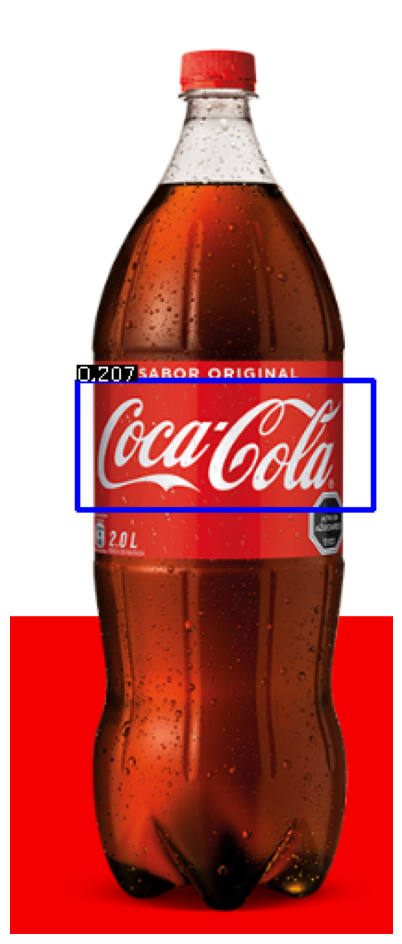

In [42]:
dets, scores = multi_detection(
    cv.imread(IMGS['coca_logo_1']),
    template,
    #method=cv.TM_CCORR_NORMED,
    #threshold=0.3,
    threshold=0.2,
    debug=True,
    plot=True
)

H-W ratios: (2.074,0.583)
Scale 0.200, 0.200:[-0.1580, 0.1530] pre-NMS=0
Scale 0.200, 0.300:[-0.1370, 0.1590] pre-NMS=0
Scale 0.200, 0.400:[-0.1430, 0.1450] pre-NMS=0
Scale 0.200, 0.500:[-0.1380, 0.1370] pre-NMS=0
Scale 0.200, 0.600:[-0.1190, 0.1170] pre-NMS=0
Scale 0.200, 0.700:[-0.1030, 0.1280] pre-NMS=0
Scale 0.200, 0.800:[-0.0930, 0.1290] pre-NMS=0
Scale 0.200, 0.900:[-0.0840, 0.1140] pre-NMS=0
Scale 0.200, 1.000:[-0.0910, 0.1100] pre-NMS=0
Scale 0.200, 1.100:[-0.0840, 0.0970] pre-NMS=0
Scale 0.200, 1.200:[-0.0830, 0.1080] pre-NMS=0
Scale 0.200, 1.300:[-0.0760, 0.1060] pre-NMS=0
Scale 0.200, 1.400:[-0.0610, 0.0970] pre-NMS=0
Scale 0.200, 1.500:[-0.0480, 0.0950] pre-NMS=0
Scale 0.200, 1.600:[-0.0410, 0.0970] pre-NMS=0
Scale 0.200, 1.700:[-0.0390, 0.0890] pre-NMS=0
Scale 0.200, 1.800:[-0.0390, 0.0730] pre-NMS=0
Scale 0.200, 1.900:[-0.0410, 0.0690] pre-NMS=0
Scale 0.200, 2.000:[-0.0320, 0.0610] pre-NMS=0
Scale 0.300, 0.200:[-0.1390, 0.1450] pre-NMS=0
Scale 0.300, 0.300:[-0.1280, 0.134

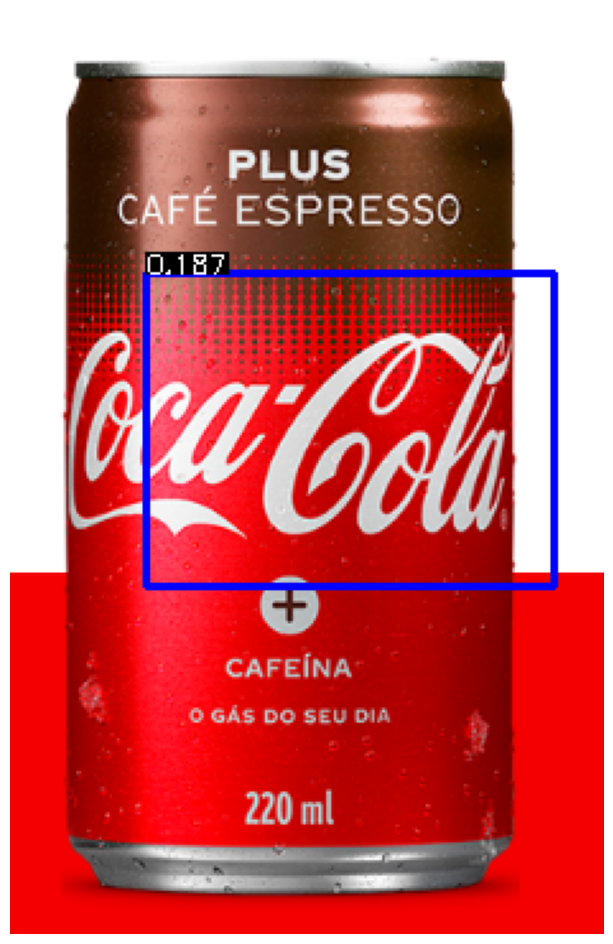

In [46]:
dets, scores = multi_detection(
    cv.imread(IMGS['coca_logo_2']),
    template,
    #method=cv.TM_CCORR_NORMED,
    #threshold=0.3,
    threshold=0.18,
    debug=True,
    plot=True
)

H-W ratios: (3.417,1.998)
Scale 0.200, 0.200:[-0.1840, 0.1860] pre-NMS=1
Scale 0.200, 0.300:[-0.1430, 0.2070] pre-NMS=18
Scale 0.200, 0.400:[-0.1210, 0.1780] pre-NMS=0
Scale 0.200, 0.500:[-0.1050, 0.1270] pre-NMS=0
Scale 0.200, 0.600:[-0.0880, 0.1260] pre-NMS=0
Scale 0.200, 0.700:[-0.0920, 0.1160] pre-NMS=0
Scale 0.200, 0.800:[-0.1000, 0.1020] pre-NMS=0
Scale 0.200, 0.900:[-0.1040, 0.0950] pre-NMS=0
Scale 0.200, 1.000:[-0.0900, 0.1110] pre-NMS=0
Scale 0.200, 1.100:[-0.0900, 0.1100] pre-NMS=0
Scale 0.200, 1.200:[-0.0980, 0.1120] pre-NMS=0
Scale 0.200, 1.300:[-0.0940, 0.1230] pre-NMS=0
Scale 0.200, 1.400:[-0.0880, 0.1120] pre-NMS=0
Scale 0.200, 1.500:[-0.0850, 0.1040] pre-NMS=0
Scale 0.200, 1.600:[-0.0860, 0.1030] pre-NMS=0
Scale 0.200, 1.700:[-0.0880, 0.1050] pre-NMS=0
Scale 0.200, 1.800:[-0.0890, 0.1000] pre-NMS=0
Scale 0.200, 1.900:[-0.0870, 0.1130] pre-NMS=0
Scale 0.200, 2.000:[-0.0800, 0.1080] pre-NMS=0
Scale 0.300, 0.200:[-0.1670, 0.1440] pre-NMS=0
Scale 0.300, 0.300:[-0.1200, 0.15

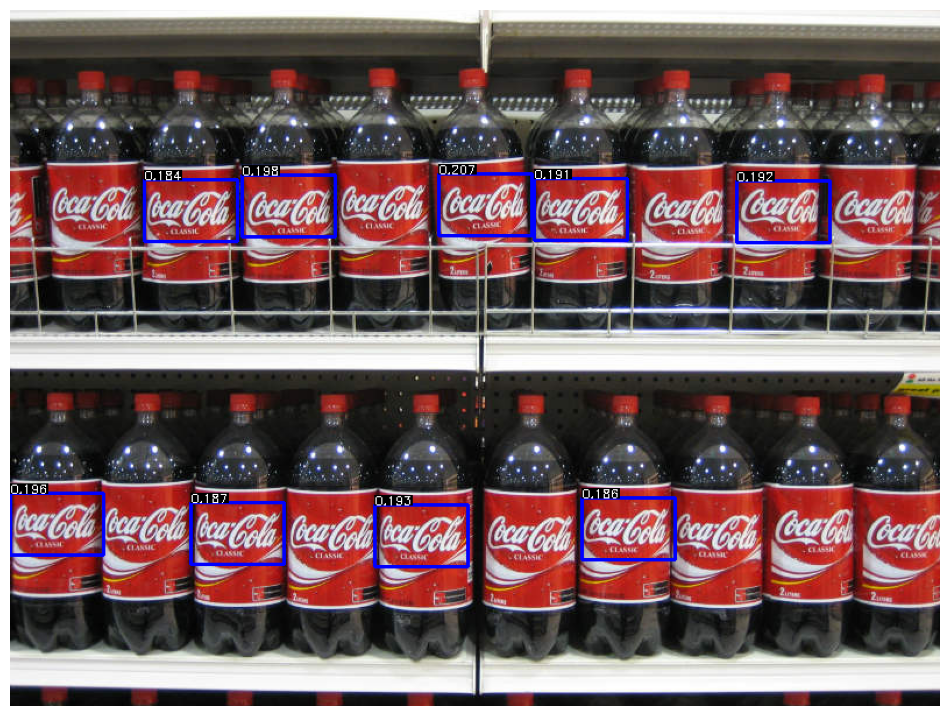

In [56]:
dets, scores = multi_detection(
    cv.imread(IMGS['coca_multi']),
    template,
    #method=cv.TM_CCORR_NORMED,
    #threshold=0.3,
    threshold=0.18,
    debug=True,
    plot=True
)

H-W ratios: (3.417,1.998)
Scale 0.200, 0.200:[-0.0000, 0.3690] pre-NMS=191
Scale 0.200, 0.300:[-0.0000, 0.3640] pre-NMS=54
Scale 0.200, 0.400:[-0.0000, 0.3260] pre-NMS=0
Scale 0.200, 0.500:[-0.0000, 0.2810] pre-NMS=0
Scale 0.200, 0.600:[0.0030, 0.2530] pre-NMS=0
Scale 0.200, 0.700:[0.0130, 0.2540] pre-NMS=0
Scale 0.200, 0.800:[0.0140, 0.2380] pre-NMS=0
Scale 0.200, 0.900:[0.0240, 0.2350] pre-NMS=0
Scale 0.200, 1.000:[0.0330, 0.2400] pre-NMS=0
Scale 0.200, 1.100:[0.0480, 0.2350] pre-NMS=0
Scale 0.200, 1.200:[0.0470, 0.2330] pre-NMS=0
Scale 0.200, 1.300:[0.0530, 0.2380] pre-NMS=0
Scale 0.200, 1.400:[0.0570, 0.2270] pre-NMS=0
Scale 0.200, 1.500:[0.0610, 0.2190] pre-NMS=0
Scale 0.200, 1.600:[0.0620, 0.2250] pre-NMS=0
Scale 0.200, 1.700:[0.0630, 0.2240] pre-NMS=0
Scale 0.200, 1.800:[0.0630, 0.2170] pre-NMS=0
Scale 0.200, 1.900:[0.0620, 0.2260] pre-NMS=0
Scale 0.200, 2.000:[0.0680, 0.2210] pre-NMS=0
Scale 0.300, 0.200:[-0.0000, 0.3290] pre-NMS=0
Scale 0.300, 0.300:[-0.0000, 0.3110] pre-NMS=0

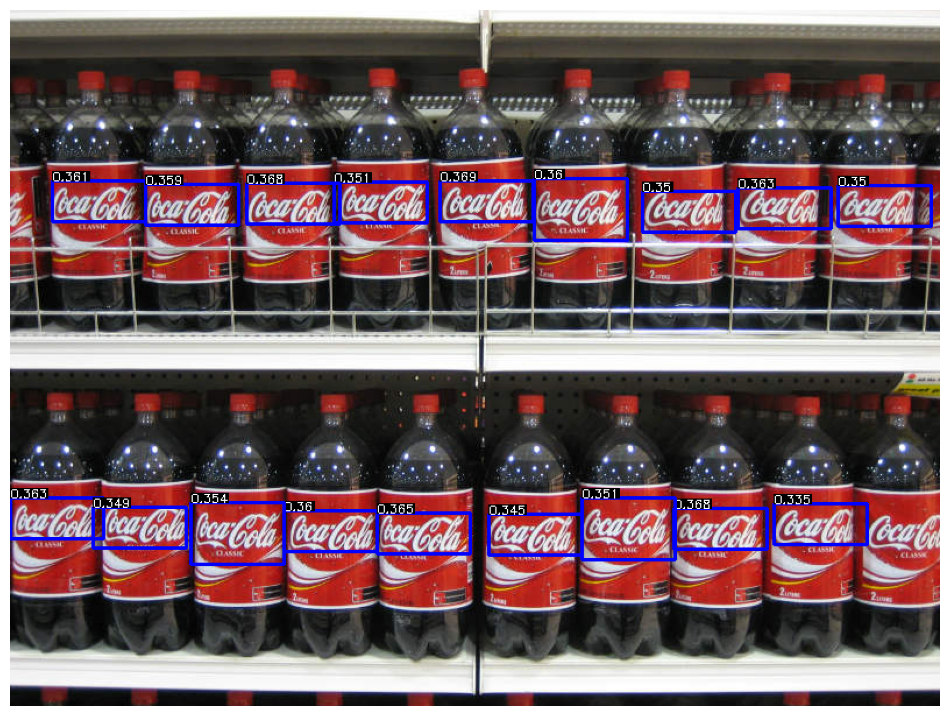

In [60]:
dets, scores = multi_detection(
    cv.imread(IMGS['coca_multi']),
    template,
    method=cv.TM_CCORR_NORMED,
    #threshold=0.3,
    threshold=0.33,
    nms_max_overlap=0.3,
    debug=True,
    plot=True
)

Ahí anduvo bastante bien, probar los otros casos también con `cv.TM_CCORR_NORMED`?

**TODO**
* Probar con `method=cv.TM_CCORR_NORMED`.
* Hacer una estrategia en la que se toma el máximo de los scores y luego el top k o un top % respecto de eso. Por ejemplo que en vez de un threshold fijo se quede con el mejor y todos los que estén a un 10% del mejor.
    1. Primera pasada sobre todos los scales e ir quedándose con el mejor valor para cada (scaleX,scaleY)
    2. Determinar el threshold en base a e.g. `threshold=best * 0.9`
    3. Sólo volver a correr aquellos (scaleX,scaleY) donde el mejor sea >= a ese threshold
* Cambiar de (scaleX,scaleY) -> (scaleX, aspect_ratio) porque hay combinaciones como (2, 0.2) que no tienen sentido.